In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import itertools as it
import matplotlib.pyplot as pl
from scipy import stats, linalg

import multiprocessing as mp
import time

from thresholding import *
import kneeliverse.rdp as rdp
import kneeliverse.kneedle as kneedle

from castle.common import independence_tests

In [2]:
#ETL
df = pd.read_csv("notas-alunos-2012-2022-anonimo.csv")
total_len=len(df)

df.drop(df[df["in_mobility"]=="Sim"].index,axis=0,inplace=True)
df.drop(["in_mobility","mobility_duration","mobility_start"],axis=1,inplace=True)
df.drop(df[(df["access_type"] == "Other_8")].index,axis=0,inplace=True)

df = df[df["regime_type"] == "Normal"] #84%
df.drop("regime_type",axis=1,inplace=True)
print("Total kept:", np.round(len(df)/total_len,2) )

df.drop(df[df["exam_type"]=="December"].index,axis=0,inplace=True)
df.drop(df[df["exam_type"]=="Semestral"].index,axis=0,inplace=True)
df.drop(df[df["exam_type"]=="Special"].index,axis=0,inplace=True)
df.drop(df[df["exam_season"]=="Special"].index,axis=0,inplace=True)

print("Total kept:", np.round(len(df)/total_len,2) )

df['istudent'] = df['istudent'].astype(str)

df.drop(df[df["was_evaluated"]==0].index,axis=0,inplace=True) #non-evaluated
df.drop(df[df["grade"]==0].index,axis=0,inplace=True) #removing zeros

print("Total kept:", np.round(len(df)/total_len,2) )

df.drop(df[df["exam_season"] == "Retake"].index,axis=0,inplace=True) #recursos

print("Total kept:", np.round(len(df)/total_len,2) )

Total kept: 0.84
Total kept: 0.83
Total kept: 0.62
Total kept: 0.5


In [3]:
B = nx.Graph()
B.add_nodes_from(df['icourse'].unique(),bipartite=0)
B.add_nodes_from(df['istudent'].unique(), bipartite=1)
B.add_edges_from(df[['istudent','icourse']].values.tolist())

G = nx.bipartite.weighted_projected_graph(B,df['icourse'].unique())
#edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

In [4]:
cut_stud = 20
H = G.edge_subgraph([(a,b) for a, b, attrs in G.edges(data=True) if attrs["weight"] >= cut_stud]).copy()
H = H.subgraph(list(nx.connected_components(H))[0])

n_weights = [ (df["icourse"] == disc).sum() for disc in H.nodes]

rest = list(range(16))+[20,21] # all deps except 16,17,18,19

n_colors = []
blue = np.array([31, 119, 180])
green = np.array([44, 160, 44])
red = np.array([214, 39, 40])
white=np.array([255,255,255])
yellow=np.array([255,255,0])
for disc in H.nodes:
    total = np.array([0, 0, 0])
    dep = list(df.loc[df["icourse"] == disc,"idepartment"].unique())
    if 16 in dep and len(dep)==1:
        total = green
    elif 17 in dep and len(dep)==1:
        total = yellow
    elif 18 in dep and len(dep)==1:
        total = red
    elif 19 in dep and len(dep)==1:
        total = white
    else:
        total = blue
    total = total/255
    n_colors.append( total )

edges, weights = zip(*nx.get_edge_attributes(H, 'weight').items())
e_weights = [w * 0.01 for w in weights]

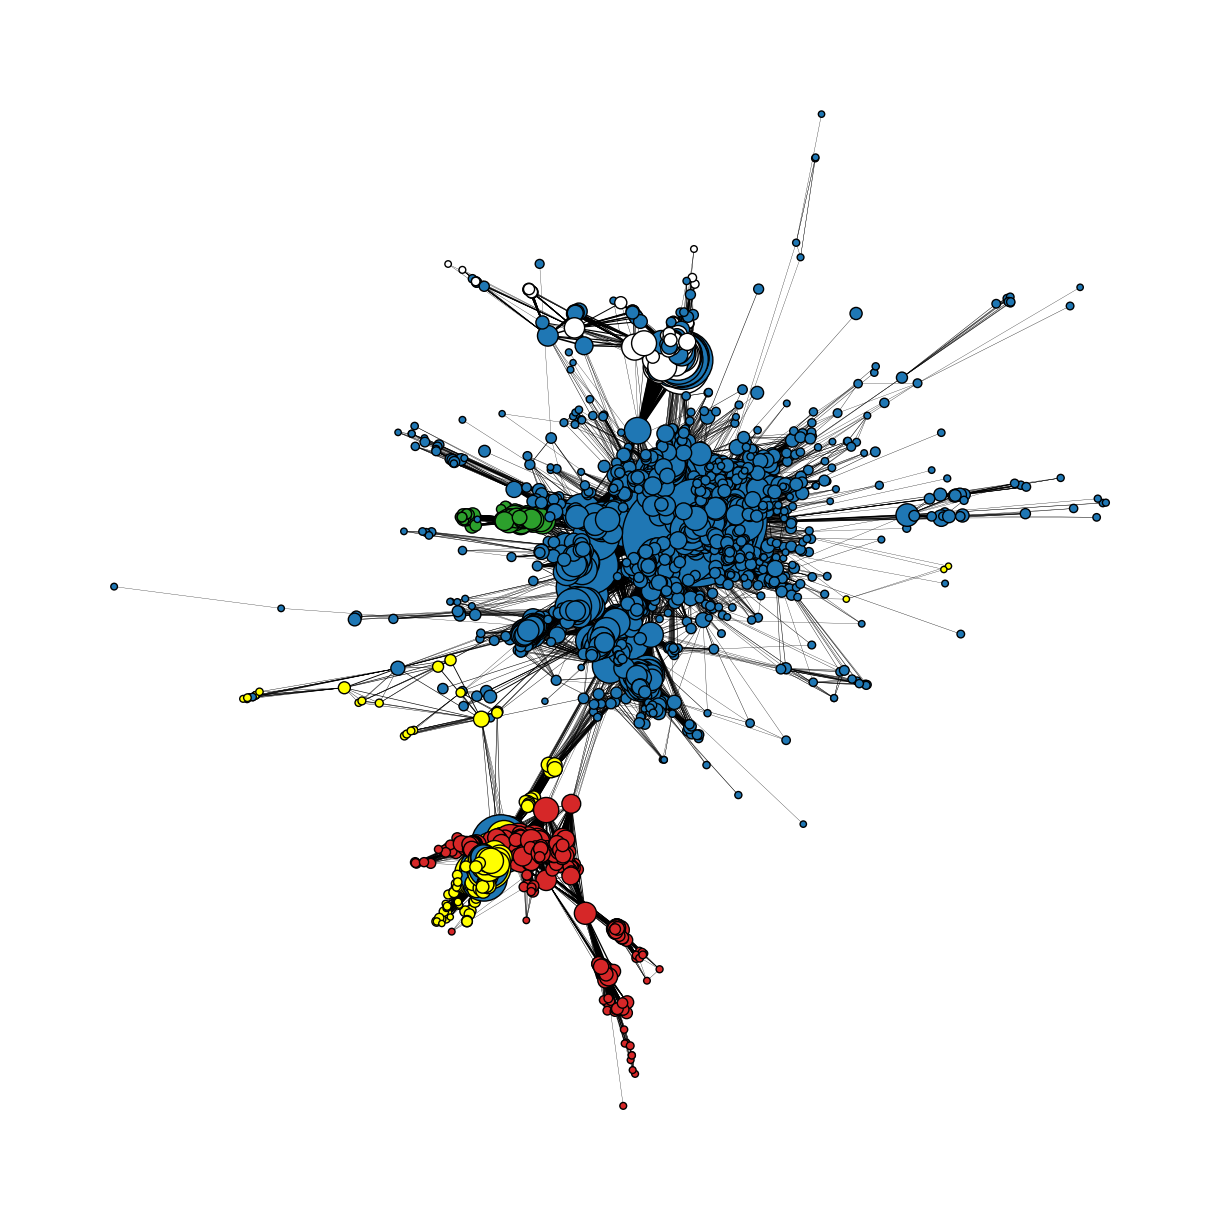

In [5]:
pl.figure(figsize=(12,12))
nx.draw(H, node_size=n_weights, node_color=n_colors,
        width=e_weights, edgecolors='black')
#pl.savefig("lcc_cut"+str(cut_stud)+"_v2")
pl.show()

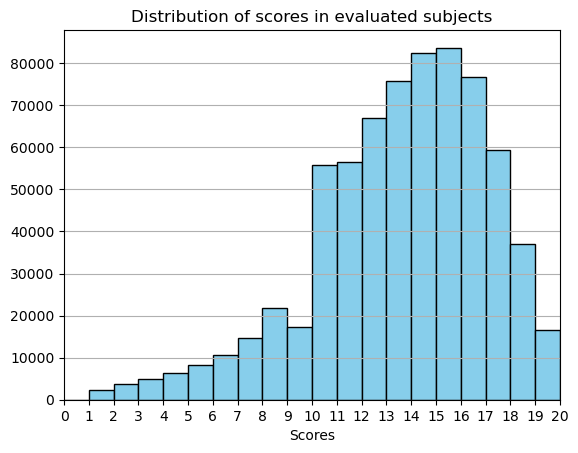

In [24]:
df.nota.hist(bins=np.arange(21),color='skyblue',edgecolor='black')
pl.xticks(np.arange(21))
pl.xlim(0,20)
#pl.ylim(0,100000)
pl.grid(axis="x")
pl.title("Distribution of scores in evaluated subjects")
pl.xlabel("Scores")
#pl.savefig("hist_scores")
pl.show()